# Step by Step Tutorial Building and Training of a Digit Recognition Model in PyTorch

[Google Colab Notebook](https://colab.research.google.com/drive/1yDIdZ3eQBhNiDY0M36UlmIc6-NZ00U4u?usp=sharing)

(Don't miss the Bonus below!) </br> Written by: Emily Li

## Imports, Dataloading, Transformations, Configs

In [222]:
# Import necessary packages
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

In [223]:
configs = {
    'batch_size': 64,
    'num_epochs': 5,
    'learning_rate': 0.01,
}

In [224]:
# Display Sample Image from MNIST

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True)

# Visualize the images
nth_image = 23
display(trainset[nth_image][0])

In [225]:
# Define a transform to normalize the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),]
    )
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

# Load the train and test data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=configs['batch_size'], shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=configs['batch_size'], shuffle=True)

print("Trainset has {} images".format(len(trainset)))
print("Testset has {} images".format(len(testset)))

Trainset has 60000 images
Testset has 10000 images


In [226]:
# dataloader sanity check
# (Running this cell is optional)
for i, data in enumerate(trainloader):
    img_inputs, targets = data
    print("img_inputs.shape: {} --> (batch_size, channel, H, W)".format(img_inputs.shape))
    print("targets.shape: {} --> (batch_size,)".format(targets.shape)) # each element contains class labels
    break

img_inputs.shape: torch.Size([64, 1, 28, 28]) --> (batch_size, channel, H, W)
targets.shape: torch.Size([64]) --> (batch_size,)


## Designing the Model

In [227]:
class Model(nn.Module):
  def __init__(self, hidden_size=128, class_num=10): # called upon model initialization
    super(Model, self).__init__()
    self.input_size = 28 # hardcoded for the MNIST dataset. You could change if you are using convolution layers

    # FEEL FREE TO CHANGE ME and experiment with various other architectures!
    # PyTorch documentation:
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(self.input_size**2, hidden_size),
      nn.ReLU(), # Nonlinear activation function
      nn.Linear(hidden_size, class_num), # Classification head
      )

  def forward(self, x): # called during forward pass (e.g model(input))
    out = self.layers(x)
    return out

model = Model()
print(model)

Model(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [228]:
# Prints out # of learnable parameters in the network
# (Running this cell is optional)
total_params = 0
for name, param in model.named_parameters():
    print('Layer: ', name, '  Params:', param.numel(), '  Size:', param.size())
    total_params += param.numel()

print("TOTAL PARAMETERS:", total_params/1e6, 'M parameters')

Layer:  layers.1.weight   Params: 100352   Size: torch.Size([128, 784])
Layer:  layers.1.bias   Params: 128   Size: torch.Size([128])
Layer:  layers.3.weight   Params: 1280   Size: torch.Size([10, 128])
Layer:  layers.3.bias   Params: 10   Size: torch.Size([10])
TOTAL PARAMETERS: 0.10177 M parameters


## Loss Function, Optimizer, Using GPU for training

In [229]:
criterion = torch.nn.CrossEntropyLoss() # Loss function. This is a measure of "how wrong" the model is at it's predictions
optimizer = torch.optim.SGD(model.parameters(), lr=configs['learning_rate']) # Optimizer. This tells the model how to adjust it's weights and by how much
                                                                      #could try Adam or AdamW

In [230]:
# Switch device to GPU if GPU is available to use parallelism to speed up training process.

# If working on Google Colab, turn on GPU by going to Runtime > Change Runtime type > GPU Accelerator > A100 (if possible). Once this new runtime is setup, re-run all previous cells
if torch.cuda.is_available():
  device = torch.cuda.current_device()
  print("GPU available: cuda:", device)
  model.to(device) # move model onto GPU
  criterion.to(device) # move loss fn onto GPU
else:
  print("GPU not available. Using CPU instead")

GPU available: cuda: 0


In [231]:
# (Running this cell is optional)
torch.cuda.empty_cache() # Releases unoccupied cache memory, but does not release the memory occupied by tensors or variable.
                          # So this may help if you are experiencing memory issues

## Train Loop, Test Loop

In [232]:
# Train loop
def train(model, trainloader, criterion, optimizer, num_epochs):
  print("Training..")

  total_loss = [] # across epochs
  total_loss_across_steps = []
  running_acc = []
  running_corrects = 0
  total_samples = 0

  for e in range(num_epochs): # loop through the # of times we want to pass training data into model

    total_loss_per_epoch = 0
    num_batches = len(trainloader)

    for i, (img_inputs, targets) in enumerate(trainloader): # loop through each minibatch in the training data set
      model.train() # enables train mode

      if torch.cuda.is_available(): # move inputs and targets onto GPU
        img_inputs = img_inputs.to(device)
        targets = targets.to(device)

      outputs = model(img_inputs) # forward pass/propagation

      loss = criterion(outputs, targets) # calculate loss

      optimizer.zero_grad() # clear out gradients calculation from last step
      loss.backward() # backward pass/propagation
      optimizer.step() # update weights

      predicted_labels = torch.argmax(outputs, dim=1) # retrieve the most probable prediction, from 0 to 9
      running_corrects += torch.sum(predicted_labels == targets).item() # compares predicted to target labels, count how many match up
      total_samples += targets.size(0) # increment the total of samples by batch size
      running_acc.append(running_corrects / total_samples)

      total_loss_across_steps.append(loss.item())
      total_loss_per_epoch += loss.item()

    print("Finished epoch", e, "Avg loss at current epoch:", total_loss_per_epoch / num_batches)
    total_loss.append(total_loss_per_epoch / num_batches)

  avg_loss = sum(total_loss) / len(total_loss)
  print("Avg_loss:", avg_loss)

  return total_loss, total_loss_across_steps, running_acc

In [233]:
def test(model, testloader, criterion):
  print("Testing..")

  # some metrics to keep track of
  total_loss = []
  running_corrects = 0
  total_samples = 0

  for i, (img_inputs, targets) in enumerate(testloader): # loop through each minibatch in the training test set
    model.eval() # enables train mode

    with torch.no_grad(): # tells torch to not keep track of local gradients as no backward pass is done during testing
      if torch.cuda.is_available():
        img_inputs = img_inputs.to(device)
        targets = targets.to(device)

      outputs = model(img_inputs) # forward pass
      loss = criterion(outputs, targets) # loss calculation

      predicted_labels = torch.argmax(outputs, dim=1) # retrieve the most probable prediction, from 0 to 9

      running_corrects += torch.sum(predicted_labels == targets).item() # compares predicted to target labels, count how many match up
      total_samples += targets.size(0) # increment the total of samples by batch size

      total_loss.append(loss.item())

  overall_accuracy = running_corrects / total_samples
  print("overall_accuracy", overall_accuracy)
  avg_loss = sum(total_loss) / len(total_loss)
  print("avg_loss:", avg_loss)

  return total_loss

In [234]:
loss_list_train, total_loss_across_steps_train, running_acc = train(model=model,
                                                       trainloader=trainloader,
                                                       criterion=criterion,
                                                       optimizer=optimizer,
                                                       num_epochs=configs['num_epochs'])

Training..
Finished epoch 0 Avg loss at current epoch: 0.7344762925813193
Finished epoch 1 Avg loss at current epoch: 0.36590243492331076
Finished epoch 2 Avg loss at current epoch: 0.3209054270056265
Finished epoch 3 Avg loss at current epoch: 0.29566036001133766
Finished epoch 4 Avg loss at current epoch: 0.2754242635214888
Avg_loss: 0.3984737556086166


In [235]:
loss_list_test = test(model=model,
                      testloader=testloader,
                      criterion=criterion)

Testing..
overall_accuracy 0.9235
avg_loss: 0.26459309990238994


## Visualization: Loss over time

In [238]:
def visualize(metric_list,
              title='Loss over Time',
              x_label='Time',
              y_label='Loss',
              marker='o',
                   ):
  plt.plot(range(len(metric_list)), metric_list)
  plt.xlabel('Steps')
  plt.ylabel('Loss')
  plt.title(title)
  plt.show()

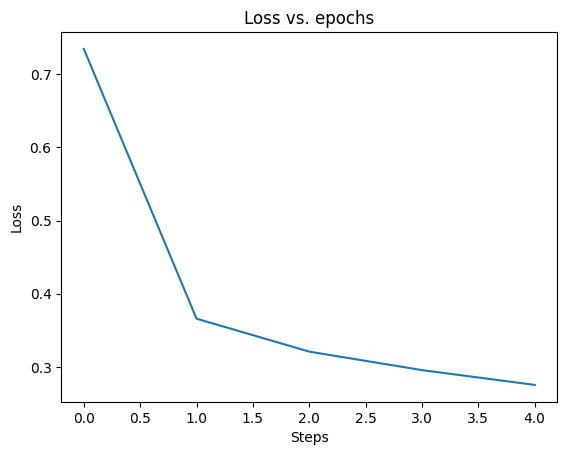

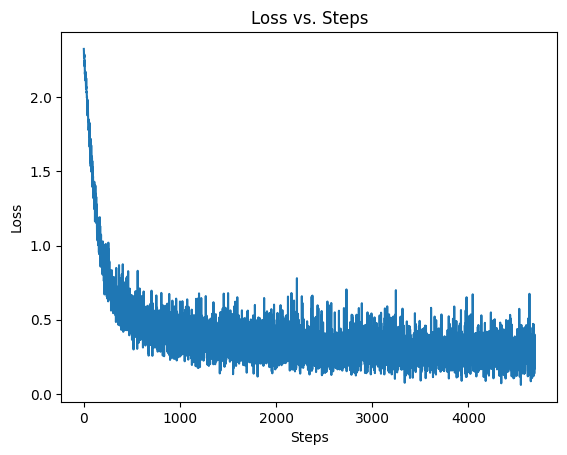

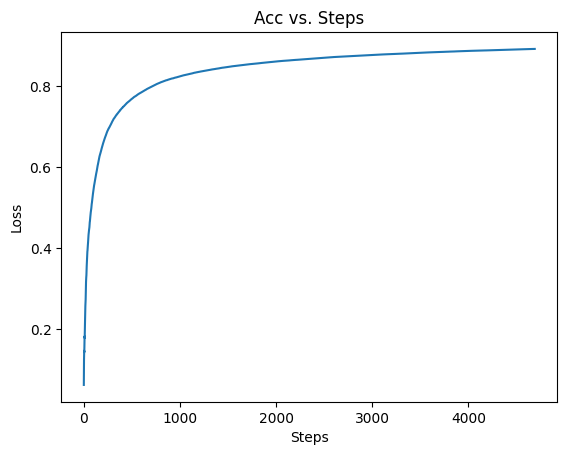

In [239]:
# Visualize learning metrics during training time
visualize(loss_list_train, title='Loss vs. epochs')
visualize(total_loss_across_steps_train, title='Loss vs. Steps')
visualize(running_acc, title='Acc vs. Steps')

## Inference

In [240]:
def inference(model, inputs: torch.Tensor) -> int:
  print("Performing Inference..")

  if torch.cuda.is_available: # Move device onto GPU if GPU is available
    model.to("cuda")
    inputs = inputs.to("cuda")

  output = model(inputs) # inference

  print("Predicted output:", output.data)
  print("Predicted output shape:", output.shape)

  pred = torch.argmax(output, dim=1) # Retrieve prediction by taking maximum logit
  print("Prediction:", pred.item())

  return pred


### Inference on an example image from the trainset

In [241]:
# Inference on an example image from the trainset

nth_img = 100 # CHANGE ME
input = trainset[nth_img][0] # Shape: (1, 28, 28)
input_is_tensor = True
pred = inference(model, input) # Inference on an example image from the trainset

if input_is_tensor:
  # Convert tensor to PIL image using Torchvision
  tensor_to_pil = transforms.ToPILImage()
  pil_image = tensor_to_pil(input)

  # Display the PIL image
  pil_image.show()


Performing Inference..
Predicted output: tensor([[-1.1303, -1.4467,  1.3810, -1.3841, -0.0055,  4.1271,  0.7681, -3.3845,
          1.8050,  1.3361]], device='cuda:0')
Predicted output shape: torch.Size([1, 10])
Prediction: 5


## Save Model Checkpoint and Loading Model from Checkpoint

In [210]:
def save_model(model, save_path:str):
  state = {
      'model_state_dict': model.state_dict(),
      # optimizers..
  }

  torch.save(state, save_path)
  print("Successfully saved in", save_path)

In [211]:
def load_model(model, checkpoint_path:str):
  state = torch.load(checkpoint_path)
  model.load_state_dict(state['model_state_dict'])
  print("Successfully loaded in model state dict weights!")
  return model

In [212]:
save_model(model, 'checkpoint.pth') # Saves model weights to checkpoint.pth

Successfully saved in checkpoint.pth


In [219]:
# If you would like to download a sample trained checkpoint for the default model,
                                                  #uncomment and run the following

#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1uSAz22XAbLwU__I6fQaiR4i-4p8RLYBA' -O checkpoint.pth

--2023-07-16 23:35:43--  https://docs.google.com/uc?export=download&id=1uSAz22XAbLwU__I6fQaiR4i-4p8RLYBA
Resolving docs.google.com (docs.google.com)... 74.125.200.113, 74.125.200.139, 74.125.200.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.200.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dgt5fivc57le6p6r54281cp85euqeoi7/1689550500000/00998986141174652771/*/1uSAz22XAbLwU__I6fQaiR4i-4p8RLYBA?e=download&uuid=49cee8f8-ae7f-49fd-a2bb-2b97e5512418 [following]
--2023-07-16 23:35:44--  https://doc-00-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dgt5fivc57le6p6r54281cp85euqeoi7/1689550500000/00998986141174652771/*/1uSAz22XAbLwU__I6fQaiR4i-4p8RLYBA?e=download&uuid=49cee8f8-ae7f-49fd-a2bb-2b97e5512418
Resolving doc-00-54-docs.googleusercontent.com (doc-00-54-docs.googleusercontent.com)... 74.125.130.132, 2404:6800:

In [218]:
# model = Model() # Make sure that the model has been defined and is the same model architecture as the model that was saved to the checkpoint!

load_model(model, checkpoint_path="checkpoint.pth") # Loads model weights from checkpoint.pth

Successfully loaded in model state dict weights!


Model(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

## Bonus: Inference on your own digit drawings

Below is a script that provides an interactive interface for a user to draw an image within a JavaScript canvas element and perform inference on the user drawn input using the model that we just trained!

In [220]:
def load_process_img(path):
  print("Loading and processing input..")
  img = Image.open(path)

  print("Original img:")
  img.show() #
  img_resized = img.resize((28, 28)) # resize into 28x28

  transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,)),]
      )

  input = transform(img_resized)[3].unsqueeze(0) # Shape: 1, 28, 28

  pil_input = transforms.ToPILImage()(input) # purely for visualization

  print("Input img:")
  pil_input.show()

  print("Successfully loaded and processed image from", path)
  return input

<IPython.core.display.Javascript object>

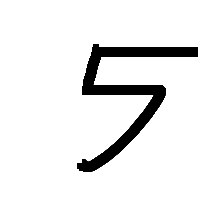

Loading and processing input..
Original img:


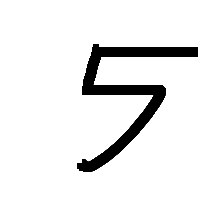

Input img:


Successfully loaded and processed image from image.png
Performing Inference..
Predicted output: tensor([[ 0.6371, -2.6640, -4.7827,  1.8084, -2.1195,  3.7867, -1.8896,  1.6636,
          0.2433,  2.9192]], device='cuda:0')
Predicted output shape: torch.Size([1, 10])
Prediction: 5


In [221]:
# Import the necessary modules
import IPython
from google.colab import output
from IPython.display import display, Javascript
from PIL import Image
import io
import cv2
import numpy as np
import base64
# JavaScript code that creates a simple canvas, allows the user to draw on it, and returns the drawing as a base64 PNG image
draw_js = '''
canvas = document.createElement('canvas');
canvas.width = 200;
canvas.height = 200;
ctx = canvas.getContext('2d');
ctx.lineWidth = 10;
var button = document.createElement('button');
button.textContent = 'Done';
var cancelButton = document.createElement('button');
cancelButton.textContent = 'Cancel';

var mouse = {x: 0, y: 0};

canvas.onmousemove = function(e){
  mouse.x = e.pageX - this.offsetLeft;
  mouse.y = e.pageY - this.offsetTop;
}

canvas.onmousedown = function(e){
  ctx.beginPath();
  ctx.moveTo(mouse.x, mouse.y);
  canvas.addEventListener('mousemove', onPaint, false);
}

canvas.onmouseup = function(e){
  canvas.removeEventListener('mousemove', onPaint, false);
}

var onPaint = function() {
    ctx.lineTo(mouse.x, mouse.y);
    ctx.stroke();
};

var data = new Promise((resolve, reject) => {
  button.onclick = () => {
    resolve(canvas.toDataURL('image/png'));
  }
  cancelButton.onclick = () => {
    ctx.clearRect(0, 0, canvas.width, canvas.height); // clear the canvas
    reject('Drawing cancelled');
  }
});

document.body.appendChild(canvas);
document.body.appendChild(button);
document.body.appendChild(cancelButton);

data
'''

def draw():
  display(Javascript(draw_js))
  try:
    data = output.eval_js('data')
    header, data = data.split(',')
    binary = base64.b64decode(data)
    with open('image.png', 'wb') as f:
      f.write(binary)
    return 'image.png'
  except Exception as e:
    print(str(e))
    return None

filename = draw()
if filename is not None:
    display(Image.open(filename))


input = load_process_img(path='image.png') # processes image at 'image.png' and prepares it for inference
pred = inference(model, input) # performs inference on image drawn


## Advanced Exercises & Topics to Research

- How low of a training loss and high of a validation accuracy can you achieve with various types of networks and layers (e.g convolutional layers)?
- What are the shapes of the weights/learnable parameters of each layer and what layers have more parameters? Is it reasonable
- Since the MNIST has already been prepared by PyTorch for us to load, how could we build custom dataloader for our custom dataset?
- The optimizer we used is vanilla Stocastic Gradient Descent (SGD), and there are more modern optimizers out there (e.g Adam, AdamW, Sophia), what do they do differently?
- NMIST is a relatively easy dataset to achieve high accuracy on. Try training a model for a task that is harder to understand concepts such as overfitting, underfitting, etc...